In [1]:
#from https://github.com/jfpuget/DSB_2018/blob/master/keras_unet_67_final_save.ipynb

In [2]:
"""from zipfile import ZipFile
a = ZipFile('Stage2_train.zip', 'r')
a.extractall()
a.close()
a = ZipFile('Stage2_test.zip', 'r')
a.extractall()
a.close()"""

"from zipfile import ZipFile\na = ZipFile('Stage2_train.zip', 'r')\na.extractall()\na.close()\na = ZipFile('Stage2_test.zip', 'r')\na.extractall()\na.close()"

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import sys
import random
import warnings

import numpy as np
import pandas as pd

import cv2
from cv2 import imread as cv_im
from glob import glob

import matplotlib.pyplot as plt
%matplotlib inline
#import seaborn as sns

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label, binary_erosion, binary_dilation, disk
from skimage.morphology import square, watershed, closing, binary_closing
from skimage.morphology import remove_small_holes, remove_small_objects
from skimage.filters.rank import gradient
from skimage.exposure import rescale_intensity
from skimage.segmentation import random_walker

from sklearn.model_selection import KFold
from scipy.ndimage.morphology import binary_fill_holes

from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D

from inception_resnet_v2 import *

#from imgaug import augmenters as iaa

import tensorflow as tf

import pickle as pkl
import gc

root = os.getcwd()

# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = 'Stage2_train/'
TEST_PATH = 'Stage2_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorflow.contrib.keras.python'

In [4]:
import random as rn
def init_seeds(seed):
    os.environ['PYTHONHASHSEED'] = '0'

    # The below is necessary for starting Numpy generated random numbers
    # in a well-defined initial state.

    np.random.seed(seed)

    # The below is necessary for starting core Python generated random numbers
    # in a well-defined state.

    rn.seed(seed)

    # Force TensorFlow to use single thread.
    # Multiple threads are a potential source of
    # non-reproducible results.
    # For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

    from keras import backend as K

    # The below tf.set_random_seed() will make random number generation
    # in the TensorFlow backend have a well-defined initial state.
    # For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

    tf.set_random_seed(seed)

    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)
    return sess

In [5]:
grid_size = 8
def rgb_clahe(in_rgb_img): 
    bgr = in_rgb_img[:,:,[2,1,0]] # flip r and b
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(grid_size,grid_size))
    lab[:,:,0] = clahe.apply(lab[:,:,0])
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return bgr[:,:,[2,1,0]]

def mark_contours(mask):
    """Pass in a 2-dimensional grayscale mask, mark contours of the mask,
    and return the 2-dimensional grayscale contoured mask
    """
    #padded = 2
    
    mask = mask.astype(np.uint8)*255
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    (thresh, mask) = cv2.threshold(mask,127,255,cv2.THRESH_BINARY)
    _, contours, _ = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contoured_rgb = cv2.drawContours(mask,contours,-1,(255,255,255),1) 
        
    
    # workaround due to OpenCV issue, the contour starts from the 1st pixel
    #contoured_mask = contoured_gray[padded:-padded,padded:-padded]

    return contoured_gray#contoured_mask 

In [6]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

np.random.seed(0)
perm = np.random.permutation(len(train_ids))
train_ids = [train_ids[i] for i in perm]

# Get the data
Let's first import all the images and associated masks. I downsample both the training and test images to keep things light and manageable, but we need to keep a record of the original sizes of the test images to upsample our predicted masks and create correct run-length encodings later on. There are definitely better ways to handle this, but it works fine for now!

In [7]:
train = []
train_mask = []


for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    file = "Stage2_train/{}/images/{}.png".format(id_,id_)
    mfile = "Stage2_train/{}/masks/*.png".format(id_)
    image = cv2.imread(file)
    image = rescale_intensity(image, out_range=np.uint8)
    masks = imread_collection(mfile).concatenate()
    train.append(image)
    train_mask.append(masks)

100%|██████████| 664/664 [00:58<00:00, 11.39it/s]


In [8]:
test = [] 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    file = "Stage2_test/{}/images/{}.png".format(id_,id_)
    image = cv2.imread(file)
    image = rescale_intensity(image, out_range=np.uint8)
    test.append(image)
    

100%|██████████| 3019/3019 [00:29<00:00, 102.34it/s]


In [9]:
#Otsu thresholding

def to_flip(img_rgb):
    # do not flip colored images
    if (img_rgb[:,:,0] != img_rgb[:,:,1]).any():
        return img_rgb
    #green channel happens to produce slightly better results
    #than the grayscale image and other channels
    img_gray=img_rgb[:,:,1]#cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    #morphological opening (size tuned on training data)
    circle7=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    img_open=cv2.morphologyEx(img_gray, cv2.MORPH_OPEN, circle7)
    #Otsu thresholding
    img_th=cv2.threshold(img_open,0,255,cv2.THRESH_OTSU)[1]
    #Invert the image in case the objects of interest are in the dark side
    if (np.sum(img_th==255)>np.sum(img_th==0)):
        return img_rgb
    else:
        return 255 - img_rgb

183.87735595703126


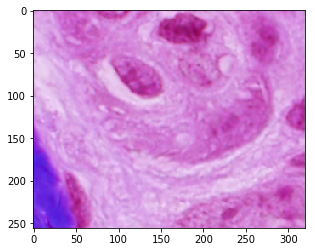

In [10]:
print(train[190].mean())
plt.imshow(train[190])

31.83193445243805


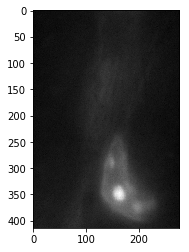

In [11]:
print(test[190].mean())
plt.imshow(test[190])

In [12]:
train = [to_flip(img) for img in train]
#train = [rgb_clahe(img_rgb) for img_rgb in train]

test = [to_flip(img) for img in test]
#test = [rgb_clahe(img_rgb) for img_rgb in test]

<built-in method mean of numpy.ndarray object at 0x7f26b04b6440>


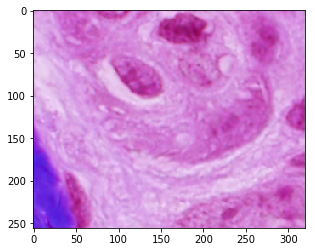

In [13]:
print(train[190].mean)
plt.imshow(train[190])

223.16806554756195


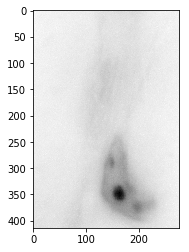

In [14]:
print(test[190].mean())
plt.imshow(test[190])

In [15]:
def split_aux(img):
    height = img.shape[0]
    width = img.shape[1]
    if height > 2*width:
        half = int(height//2)
        return [img[:half, :, :], img[half:, :, :]]
    elif height > width:
        return [img[:width, :, :], img[height-width:, :, :]]
    elif width > 2*height:
        half = int(width//2)
        return [img[:, :half, :], img[:, half:, :]]
    else:
        return [img[:, :height, :], img[:, width-height:, :]]

def split(img):
    s = split_aux(img)
    return s
        
def split_mask_aux(img):
    height = img.shape[1]
    width = img.shape[2]
    if height > 2*width:
        half = int(height//2)
        return [img[:, :half, :], img[:, half:, :]]
    elif height > width:
        return [img[:, :width, :], img[:, height-width:, :]]
    elif width > 2*height:
        half = int(width//2)
        return [img[:, :, :half], img[:, :, half:]]
    else:
        return [img[:, :, :height], img[:, :, width-height:]]

def split_mask(img):
    s = split_mask_aux(img)
    return s

In [16]:
train_split = [split(img) for img in train]
train_split = [t_split[i] for t_split in train_split for i in [0, 1] ]

train_mask_split = [split_mask(img) for img in train_mask]
train_mask_split = [t_split[i] for t_split in train_mask_split for i in [0, 1] ]

In [17]:
test_split = [split(img) for img in test]
test_split = [t_split[i] for t_split in test_split for i in [0, 1] ]

In [16]:
# Get and resize train images and masks
X_train = np.zeros((len(train_split) * 4, IMG_HEIGHT, IMG_WIDTH, 3), np.uint8)
Y_train = np.zeros((len(train_split) * 4, IMG_HEIGHT, IMG_WIDTH, 1), np.uint8)
Z_train = np.zeros((len(train_split) * 4, IMG_HEIGHT, IMG_WIDTH, 3), np.uint8)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, (img, masks) in enumerate(zip(tqdm(train_split), train_mask_split)):
    img = img[:, :, :IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)
    img_mean = np.mean(img, axis=2).astype(np.uint8)
    for c in range(IMG_CHANNELS):
        img[:,:,c] = img_mean
    X_train[n * 4 + 0] = img
    X_train[n * 4 + 1] = np.fliplr(img)
    X_train[n * 4 + 2] = np.flipud(img)
    X_train[n * 4 + 3] = np.flipud(np.fliplr(img))

    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    mask_lr = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    mask_ud = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    mask_lr_ud = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    for mask_id in range(masks.shape[0]):
        mask_ = masks[mask_id, :, :]
        mask_ = mask_ // 255
        mask_ = resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                       preserve_range=True).astype(np.uint8)
        #mask_ = mark_contours(mask_)
        mask = np.maximum(mask, mask_)
        mask_lr = np.maximum(mask_lr, np.fliplr(mask_))
        mask_ud = np.maximum(mask_ud, np.flipud(mask_))
        mask_lr_ud = np.maximum(mask_lr_ud, np.flipud(np.fliplr(mask_)))
        
    Y_train[4*n + 0, :, :, 0] = mask
    Y_train[4*n + 1, :, :, 0] = mask_lr
    Y_train[4*n + 2, :, :, 0] = mask_ud
    Y_train[4*n + 3, :, :, 0] = mask_lr_ud
  
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    mask_lr = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    mask_ud = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    mask_lr_ud = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    for mask_id in range(masks.shape[0]):
        mask_ = masks[mask_id, :, :]
        mask_ = mask_ // 255
        mask_ = resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                       preserve_range=True).astype(np.uint8)
        #mask_ = mark_contours(mask_)
        mask_ = binary_dilation(mask_, selem=square(3))
        mask += mask_
        mask_lr += np.fliplr(mask_)
        mask_ud += np.flipud(mask_)
        mask_lr_ud += np.flipud(np.fliplr(mask_))
        
    Z_train[4*n + 0, :, :, 0] = (mask > 1)
    Z_train[4*n + 1, :, :, 0] = (mask_lr > 1)
    Z_train[4*n + 2, :, :, 0] = (mask_ud > 1)
    Z_train[4*n + 3, :, :, 0] = (mask_lr_ud > 1)

Getting and resizing train images and masks ... 


100%|██████████| 1328/1328 [10:44<00:00,  2.06it/s]


In [17]:
for i in tqdm(range(len(train_split) * 4)):
    Z_train[i, :, :, 1] = Y_train[i, :, :, 0]
    Z_train[i, :, :, 2] = np.where(Z_train[i, :, :, 0] == 1, 0, 1 - Y_train[i, :, :, 0])
    #Z_train = [mark_contours(mask) for mask in Z_train]

100%|██████████| 5312/5312 [00:01<00:00, 4454.94it/s]


In [18]:
# Get and resize test images and masks
X_test = np.zeros((len(test_split) * 4, IMG_HEIGHT, IMG_WIDTH, 3), np.uint8)
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, img in enumerate(tqdm(test_split)):
    img = img[:, :, :3]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    img_mean = np.mean(img, axis=2).astype(np.uint8)
    for c in range(IMG_CHANNELS):
        img[:,:,c] = img_mean
    X_test[n * 4 + 0] = img
    X_test[n * 4 + 1] = np.fliplr(img)
    X_test[n * 4 + 2] = np.flipud(img)
    X_test[n * 4 + 3] = np.flipud(np.fliplr(img))    

Getting and resizing test images ... 


100%|██████████| 6038/6038 [01:16<00:00, 78.50it/s]


In [18]:

"""with open('X_train.pkl', 'wb') as file:
    pkl.dump(X_train, file, protocol=pkl.HIGHEST_PROTOCOL)

with open('Z_train.pkl', 'wb') as file:
    pkl.dump(Z_train, file, protocol=pkl.HIGHEST_PROTOCOL)

with open('X_test.pkl', 'wb') as file:
    pkl.dump(X_test, file, protocol=pkl.HIGHEST_PROTOCOL)

    """
with open('X_train.pkl', 'rb') as file:
    X_train= pkl.load(file)

with open('Z_train.pkl', 'rb') as file:
    Z_train = pkl.load(file)

with open('X_test.pkl', 'rb') as file:
    X_test = pkl.load(file)



In [19]:
def pixelwise_crossentropy(target, output):
    _epsilon = 10e-8
    output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
    weight = 30 * target[:,:,:,0:1] + 3 * target[:,:,:,1:2] + 1 * target[:,:,:,2:3]
    return - tf.reduce_sum(target * weight *  tf.log(output) +
                           (1 - target)  *  tf.log(1 - output),
                           len(output.get_shape()) - 1)


In [20]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, ZeroPadding2D, Activation, add, concatenate, average, Conv2DTranspose
from keras.layers.core import SpatialDropout2D
from keras.optimizers import Adam
from keras.models import Model
from keras import initializers
from keras.engine import Layer, InputSpec
from keras import backend as K
from keras import layers

In [21]:
def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding="same", kernel_initializer="he_normal", strides=strides, name=prefix + "_conv")(prevlayer)
    conv = BatchNormalization(name=prefix + "_bn")(conv)
    conv = Activation('relu', name=prefix + "_activation")(conv)
    return conv

In [22]:
import tensorflow as tf
from keras import models
from keras import layers
from inception_resnet_v2 import * #from keras.applications import inception_resnet_v2

#base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(256,256,3))
#base_model.summary()

In [23]:
def unet_irv2(input_shape):
    
    img_input = Input((input_shape))
    #x = Lambda(lambda x:(x/255)-1)(img_input)
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    conv1 = base_model.get_layer('conv2d_bn3_ac').output#112
    conv2a = base_model.get_layer('conv2d_bn4_ac').output#56
    conv2b = base_model.get_layer('conv2d_bn5_ac').output#56
    conv3a = base_model.get_layer('mixed_5b').output
    conv3b = base_model.get_layer('block35_8_ac').output
    conv3c = base_model.get_layer('mixed6a_branch1_ac').output#28,28
    conv4a = base_model.get_layer('mixed_6a').output#14,14
    conv4b = base_model.get_layer('block17_8_ac').output#14
    conv4c = base_model.get_layer('mixed_7a_branch_2_ac').output#14,14
    conv5 = base_model.get_layer('conv_7b_ac').output
    
    up6 = concatenate([UpSampling2D()(conv5), conv4a], axis=-1)
    conv6_1 = conv_block_simple(up6, 256, "conv6_1")
    conv6_2 = conv_block_simple(conv6_1, 256, "conv6_2")
    up6 = concatenate([UpSampling2D()(conv5), conv4b], axis=-1)
    conv6_3 = conv_block_simple(up6, 256, "conv6_3")
    conv6_4 = conv_block_simple(conv6_3, 256, "conv6_4")
    up6 = concatenate([UpSampling2D()(conv5), conv4c], axis=-1)
    conv6_5 = conv_block_simple(up6, 256, "conv6_5")
    conv6_6 = conv_block_simple(conv6_5, 256, "conv6_6")
    conv6 = concatenate([conv6_2, conv6_4, conv6_6], axis=-1)

    up7 = concatenate([UpSampling2D()(conv6), conv3a], axis=-1)
    conv7_1 = conv_block_simple(up7, 256, "conv7_1")
    conv7_2 = conv_block_simple(conv7_1, 256, "conv7_2")
    up7 = concatenate([UpSampling2D()(conv6), conv3c], axis=-1)
    conv7_5 = conv_block_simple(up7, 256, "conv7_5")
    conv7_6 = conv_block_simple(conv7_5, 256, "conv7_6")
    conv7 = concatenate([conv7_2, conv7_6], axis=-1)

    up8 = concatenate([UpSampling2D()(conv7), conv2a], axis=-1)
    conv8_1 = conv_block_simple(up8, 128, "conv8_1")
    conv8_2 = conv_block_simple(conv8_1, 128, "conv8_2")
    up8 = concatenate([UpSampling2D()(conv7), conv2b], axis=-1)
    conv8_3 = conv_block_simple(up8, 128, "conv8_3")
    conv8_4 = conv_block_simple(conv8_3, 128, "conv8_4")
    conv8 = concatenate([conv8_2, conv8_4])

    up9 = concatenate([UpSampling2D()(conv8), conv1], axis=-1)
    conv9 = conv_block_simple(up9, 64, "conv9_1")
    conv9 = conv_block_simple(conv9, 64, "conv9_2")

    up10 = concatenate([UpSampling2D()(conv9), base_model.input], axis=-1)
    conv10 = conv_block_simple(up10, 48, "conv10_1")
    conv10 = conv_block_simple(conv10, 32, "conv10_2")
    conv10 = SpatialDropout2D(0.4)(conv10)
    
    x = Conv2D(3, (1, 1), activation="sigmoid", name="prediction")(conv10)
    model = Model(base_model.input, x)
    
    return model

model = unet_irv2((256,256,3))

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
conv10_1_bn (BatchNormalization (None, 256, 256, 48) 192         conv10_1_conv[0][0]              
__________________________________________________________________________________________________
conv10_1_activation (Activation (None, 256, 256, 48) 0           conv10_1_bn[0][0]                
__________________________________________________________________________________________________
conv10_2_conv (Conv2D)          (None, 256, 256, 32) 13856       conv10_1_activation[0][0]        
__________________________________________________________________________________________________
conv10_2_bn (BatchNormalization (None, 256, 256, 32) 128         conv10_2_conv[0][0]              
__________________________________________________________________________________________________
conv10_2_activation (Activation (None, 256, 256, 32) 0           conv10_2_bn[0][0]                
__________

In [24]:
from imgaug import augmenters as iaa

def get_perspective_transform_sequence(sigma):
    return iaa.Sequential([iaa.PerspectiveTransform(scale=(float(sigma/10), sigma), deterministic=True)], deterministic=True)

def perspective_transform(images, sequence):
    if len(images[0].shape) > 2 and images[0].shape[2] == 2:
        images = [img.astype(dtype=np.uint8) for img in images]
        images = sequence.augment_images(images)
        images = [img.astype(dtype=np.bool) for img in images]
    else:
        images = sequence.augment_images(images)
    return images
  

In [25]:
#generate augmented data
augmented_x_train = list(X_train.copy())
augmented_z_train = list(Z_train.copy())

sequence = get_perspective_transform_sequence(.1)
#sequence2 = get_piecewise_affine_sequence(.15)

augmented_x_train.extend(perspective_transform(X_train, sequence))
augmented_z_train.extend(perspective_transform(Z_train, sequence))
#augmented_x_train.extend(piecewise_Affine(X_train, sequence))
#augmented_z_train.extend(piecewise_Affine(Z_train, sequence))
#augmented_x_train.extend(additive_Gaussian_noise(x_train, 0.15))
#augmented_z_train.extend(additive_Gaussian_noise(z_train, 0.15))

augmented_x_train = np.array(augmented_x_train)
augmented_z_train = np.array(augmented_z_train)

In [26]:
from sklearn.model_selection import train_test_split
x_train, x_val, z_train, z_val = train_test_split(augmented_x_train, augmented_z_train, test_size=0.1, random_state=8011)

In [27]:
print(z_train.shape)
print(x_train.shape)

(9561, 256, 256, 3)
(9561, 256, 256, 3)


In [28]:
try:
    sess.close()
except:
    pass

sess = init_seeds(0)

In [32]:
from keras.callbacks import ModelCheckpoint

model.compile(optimizer=Adam(clipvalue=5.0), loss=pixelwise_crossentropy)

checkpoint = ModelCheckpoint('IRNv2_UNet.h5', verbose=1, save_best_only=True)
model.fit(x_train, z_train, batch_size=16, epochs=25, validation_data = (x_val, z_val), callbacks=[checkpoint])

Train on 9561 samples, validate on 1063 samples
Epoch 1/25
9561/9561 [==============================] - 351s 37ms/step - loss: 0.5461 - val_loss: 0.3140

Epoch 00001: val_loss improved from inf to 0.31405, saving model to IRN-152_UNet.h5
Epoch 2/25
9561/9561 [==============================] - 284s 30ms/step - loss: 0.2662 - val_loss: 0.2754

Epoch 00002: val_loss improved from 0.31405 to 0.27539, saving model to IRN-152_UNet.h5
Epoch 3/25
9561/9561 [==============================] - 284s 30ms/step - loss: 0.2436 - val_loss: 0.3506

Epoch 00003: val_loss did not improve from 0.27539
Epoch 4/25
9561/9561 [==============================] - 285s 30ms/step - loss: 0.2223 - val_loss: 0.2231

Epoch 00004: val_loss improved from 0.27539 to 0.22306, saving model to IRN-152_UNet.h5
Epoch 5/25
9561/9561 [==============================] - 285s 30ms/step - loss: 0.2069 - val_loss: 0.2111

Epoch 00005: val_loss improved from 0.22306 to 0.21112, saving model to IRN-152_UNet.h5
Epoch 6/25
9561/9561 [=

In [ ]:
"""from keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(rotation_range=90.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.1)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)
image_datagen.fit(augmented_x_train, seed=7)
mask_datagen.fit(augmented_z_train, seed=7)
image_generator = image_datagen.flow(x_train, batch_size=4, seed=7)
mask_generator = mask_datagen.flow(z_train, batch_size=4, seed=7)
train_generator = zip(image_generator, mask_generator)

val_gen_args = dict()
image_datagen_val = ImageDataGenerator(**val_gen_args)
mask_datagen_val = ImageDataGenerator(**val_gen_args)
image_datagen_val.fit(x_val, seed=7)
mask_datagen_val.fit(z_val, seed=7)
image_generator_val = image_datagen_val.flow(x_val, batch_size=8, seed=7)
mask_generator_val = mask_datagen_val.flow(z_val, batch_size=8, seed=7)
valid_generator=zip(image_generator_val, mask_generator_val)

earlystopper = EarlyStopping(patience=8, verbose=1)
checkpointer = ModelCheckpoint('Resnet152_UNet.h5', verbose=1, save_best_only=True)

model.fit_generator(train_generator, steps_per_epoch=len(x_train)/16, epochs=25,
                    validation_data=valid_generator, validation_steps=len(x_val)/16,
                   callbacks=[checkpointer])
"""

# Make predictions

Let's make predictions both on the test set, the val set and the train set (as a sanity check). Remember to load the best saved model if you've used early stopping and checkpointing.

In [24]:
try:
    sess.close()
except:
    pass

sess = init_seeds(0)
#kf = KFold(6, shuffle=False)

In [25]:
"""
#preds_train = np.zeros(Z_train.shape)
preds_test = 0
# Predict on train, val and test
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    model = load_model('Resnet152_UNet.h5', 
                       custom_objects={'pixelwise_crossentropy':pixelwise_crossentropy,
                                       'SpeckleNoise':SpeckleNoise, 
                                       'Scale':Scale
                                      })
    #X_val_kf = X_train[val_idx]
    #preds_train[val_idx] = model.predict(X_val_kf, verbose=1)
    preds_test += model.predict(X_test, verbose=1)
preds_test /= 6
"""



"\n#preds_train = np.zeros(Z_train.shape)\npreds_test = 0\n# Predict on train, val and test\nfor fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):\n    model = load_model('Resnet152_UNet.h5', \n                       custom_objects={'pixelwise_crossentropy':pixelwise_crossentropy,\n                                       'SpeckleNoise':SpeckleNoise, \n                                       'Scale':Scale\n                                      })\n    #X_val_kf = X_train[val_idx]\n    #preds_train[val_idx] = model.predict(X_val_kf, verbose=1)\n    preds_test += model.predict(X_test, verbose=1)\npreds_test /= 6\n"

In [26]:
from keras.models import load_model

model = load_model('IRN-152_UNet.h5', 
                       custom_objects={'pixelwise_crossentropy':pixelwise_crossentropy})

preds_test = model.predict(X_test, verbose=1)



24152/24152 [==============================] - 1052s 44ms/step


In [27]:
def merge(img1, img2, shape):
    ov2 = 5
    height = shape[0]
    width = shape[1]
    img = np.zeros((height, width, 3), dtype=np.float32)
    w = np.zeros((height, width, 1), dtype=np.float32)
    height1 = img1.shape[0]
    width1 = img1.shape[1]
    height2 = img2.shape[0]
    width2 = img2.shape[1]  
    w1 = 10*ov2*np.ones((height1, width1, 1), dtype=np.float32)
    w2 =  10*ov2*np.ones((height2, width2, 1), dtype=np.float32)
    for i in range(ov2, 0, -1):
        w1[i-1,:] = 10*i
        w1[height1 - i, :] = 10*i
        w1[:, i-1] = 10*i
        w1[:, width1 - i] = 10*i
        w2[i-1,:] = 10*i
        w2[height2 - i, :] = 10*i
        w2[:, i-1] = 10*i
        w2[:, width2 - i] = 10*i

    if height > 2*width:
        half = int(height//2)
        img[:half, :, :] += w1*img1
        img[half:, :, :] += w2*img2
        w[:half, :] += w1
        w[half:, :] += w2
        img /= w
    elif height > width:
        img[:width, :, :] += w1*img1
        img[height-width:, :, :] += w2*img2
        w[:width, :] += w1
        w[height-width:, :] += w2
        img /= w
    elif width > 2*height:
        half = int(width//2)
        img[:, :half, :] += w1*img1
        img[:, half:, :] += w2*img2
        w[:, :half] += w1
        w[:, half:] += w2
        img /= w
    else:
        img[:, :height, :] += w1*img1 
        img[:, width-height:, :] += w2*img2
        w[:, :height] += w1 
        w[:, width-height:] += w1
        img /= w
    return (255*img).astype(np.uint8)

In [28]:
preds_test_upsampled = []
for i in tqdm(range(len(test_split))):
    test_i = test_split[i]
    pred = resize(np.squeeze(preds_test[4*i + 0]), 
                  (test_i.shape[0], test_i.shape[1]), 
                  mode='constant', preserve_range=True)
    pred += np.fliplr(resize(np.squeeze(preds_test[4*i + 1]), 
                  (test_i.shape[0], test_i.shape[1]), 
                  mode='constant', preserve_range=True))
    pred += np.flipud(resize(np.squeeze(preds_test[4*i + 2]), 
                  (test_i.shape[0], test_i.shape[1]), 
                  mode='constant', preserve_range=True))
    pred += np.flipud(np.fliplr(resize(np.squeeze(preds_test[4*i + 3]), 
                  (test_i.shape[0], test_i.shape[1]), 
                  mode='constant', preserve_range=True)))
    #pred = (pred > 4*threshold).astype(np.uint8)
    pred /= 4
    preds_test_upsampled.append(pred)

100%|██████████| 6038/6038 [06:39<00:00, 15.10it/s]


In [29]:
preds_test_merged = []
for ix in tqdm(range(len(test))):    
    merged = merge(preds_test_upsampled[2*ix+0], 
                 preds_test_upsampled[2*ix+1],
                 test[ix].shape
            )
    preds_test_merged.append(merged)

100%|██████████| 3019/3019 [00:21<00:00, 139.48it/s]


In [30]:

def get_labels(y):
    labels = np.zeros((y.shape[1], y.shape[2]))
    for i in range(y.shape[0]):
        labels = np.where(y[i,:,:] > 0, i+1, labels)
    return labels

def iou_score_cuk(y_true, y_pred, verbose=True, thresholds=np.arange(0.5, 1.0, 0.05)):
    y_true = get_labels(y_true)
    y_pred = get_labels(y_pred)
    # Compute number of objects
    true_objects = len(np.unique(y_true))
    pred_objects = len(np.unique(y_pred))
    if verbose:
        print("Number of true objects:", true_objects - 1)
        print("Number of predicted objects:", pred_objects - 1)
    
    intersection = np.histogram2d(y_true.flatten(), y_pred.flatten(), 
                                  bins=(true_objects, pred_objects))[0].astype('int')

    area_true = np.histogram(y_true, bins = true_objects)[0]
    area_true = np.expand_dims(area_true, -1)

    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_pred = np.expand_dims(area_pred, 0)

    union = area_true + area_pred - intersection
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9
    
    iou = intersection / union
    
    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn    
    
    prec = []
    
    if verbose:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in thresholds:
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) == 0:
            p = 1
        else:
            p = tp / (tp + fp + fn)
        if verbose:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    if verbose:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

from skimage.morphology import label



In [31]:
#post-processing functions

from scipy.ndimage.morphology import binary_fill_holes

def get_pred_watershed(upsampled, area_threshold, threshold, sep_threshold, 
             spread_threshold, alpha, connectivity=2):
    img = ((upsampled[:,:,1] > 255 * threshold) &
                    (upsampled[:,:,0] < 255 * sep_threshold))
    img = binary_fill_holes(img)
    img = remove_small_objects(img, area_threshold)
    lab_img = label(img, connectivity=connectivity)
    distance = upsampled[:,:,1] + alpha * upsampled[:,:,0]
    img = 1 * ((distance > 255 * spread_threshold) )
    
    lab_img = img * watershed(- upsampled[:,:,1], lab_img, watershed_line=True)

    y_pred = np.zeros((lab_img.max(), lab_img.shape[0], lab_img.shape[1]), np.uint16)
    i = 0
    for lab in range(lab_img.max()):
        tmp = (lab_img == lab+1)
        if np.sum(tmp.ravel()) > area_threshold:
            y_pred[i,:,:] = tmp
            i += 1
    return y_pred[:i]

from scipy.ndimage.morphology import binary_fill_holes

def get_pred_random_walker(upsampled, area_threshold, threshold, sep_threshold, 
             spread_threshold, alpha, connectivity=2):
    img = ((upsampled[:,:,1] > 255 * threshold) &
                    (upsampled[:,:,0] < 255 * sep_threshold))
    
    img = binary_fill_holes(img)
    img = remove_small_objects(img, area_threshold)
    markers = label(img, connectivity=connectivity)
    distance = upsampled[:,:,1] + alpha * upsampled[:,:,0]
    mask = ((distance > 255 * spread_threshold) )
    markers[~mask] = -1
    
    lab_img = random_walker(mask, markers)

    y_pred = np.zeros((lab_img.max(), lab_img.shape[0], lab_img.shape[1]), np.uint16)
    i = 0
    for lab in range(lab_img.max()):
        tmp = (lab_img == lab+1)
        if np.sum(tmp.ravel()) > area_threshold:
            y_pred[i,:,:] = tmp
            i += 1
    return y_pred[:i]

def get_pred(upsampled, area_threshold, threshold, sep_threshold, 
             spread_threshold, alpha, connectivity=2):
    try:
        return get_pred_random_walker(upsampled, area_threshold, threshold, 
                                          sep_threshold, spread_threshold, 
                                      alpha, connectivity)
    except:
        return get_pred_watershed(upsampled, area_threshold, threshold, 
                                          sep_threshold, spread_threshold, 
                                      alpha, connectivity)
        

In [32]:
area_threshold = 20
threshold = 0.75
sep_threshold = 0.6
spread_threshold = 0.4
alpha=0.4

def get_pred(upsampled, area_threshold=area_threshold, 
             threshold=threshold, sep_threshold=sep_threshold, 
             spread_threshold=spread_threshold, alpha=alpha, connectivity=2):
    try:
        return get_pred_random_walker(upsampled, area_threshold, threshold, 
                                          sep_threshold, spread_threshold, 
                                      alpha, connectivity=2)
    except:
        return get_pred_watershed(upsampled, area_threshold, threshold, 
                                          sep_threshold, spread_threshold, 
                                      alpha, connectivity=2)

# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths
            
def pred_to_rles(y_pred):
    for i in range(y_pred.shape[0]):
        tmp = y_pred[i]
        yield rle_encoding(tmp)


new_test_ids = []
rles = []
for n, id_ in tqdm(enumerate(test_ids)):
    y_pred = get_pred(preds_test_merged[n])
    rle = list(pred_to_rles(y_pred))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

print(len(rles))

# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('keras_unet_test.csv', index=False)

3019it [09:21,  5.38it/s]


80833
